# AQI project #

In [1]:
import os
import time
import requests
import sys

## Retreive data from html ##

In [3]:
def retrieve_html():
    for year in range(2013,2019):
        for month in range(1,13):
            if month<10:
                url='http://en.tutiempo.net/climate/0{}-{}/ws-421820.html'.format(month
                                                                          ,year)
            else:
                url='http://en.tutiempo.net/climate/{}-{}/ws-421820.html'.format(month
                                                                          ,year)
            source_texts=requests.get(url)
            text=source_texts.text.encode('utf=8')
    
            if not os.path.exists("data/html-data/{}".format(year)):
                os.makedirs("data/html-data/{}".format(year))
            with open("data/html-data/{}/{}.html".format(year,month),"wb") as output:# wb is write mode
                output.write(text)

        sys.stdout.flush()
            
        

### Plotting AQI data ### 

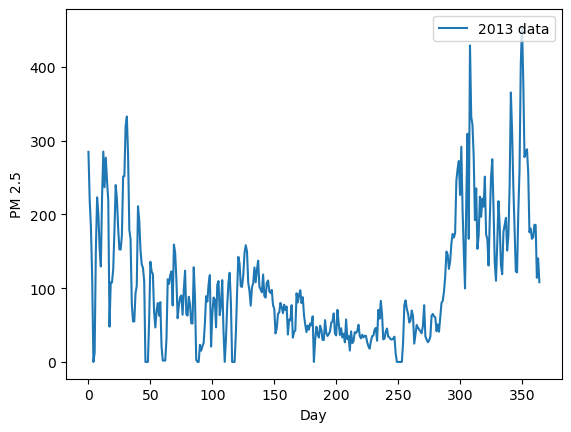

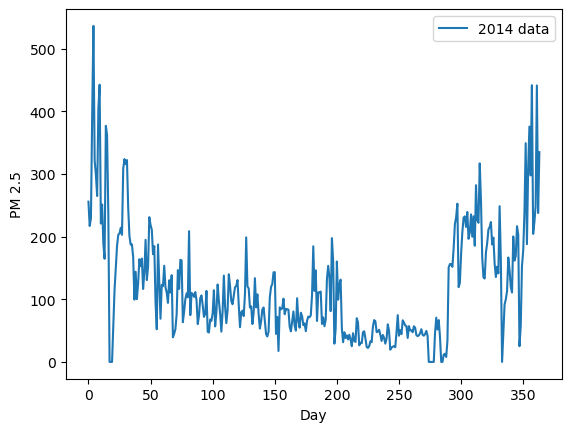

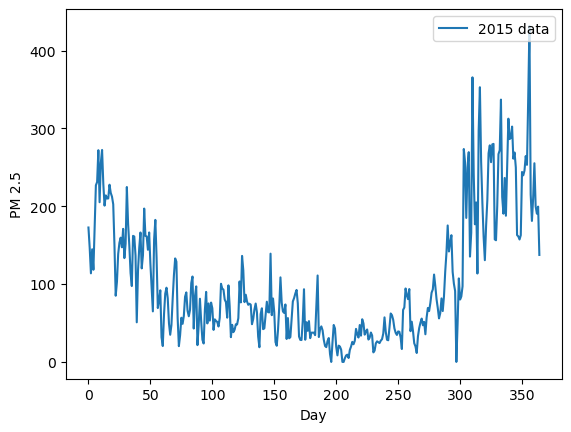

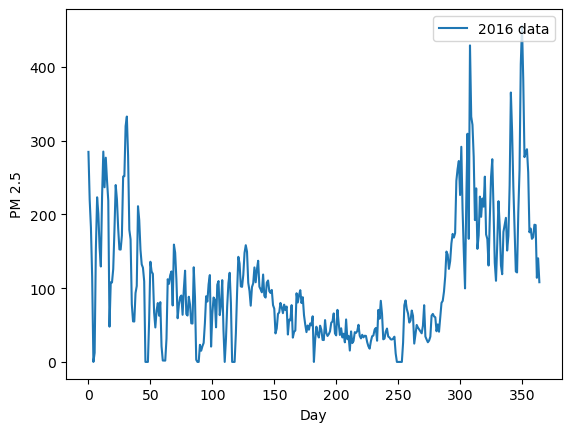

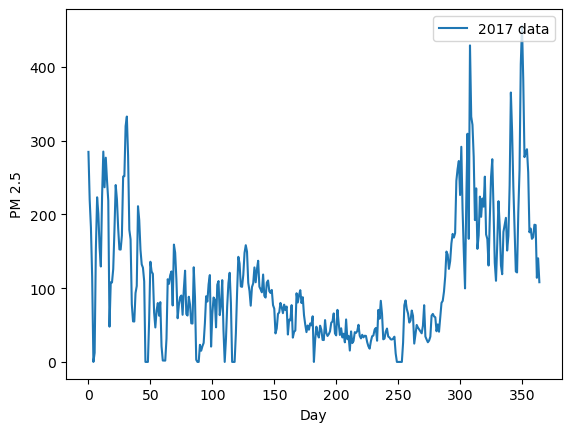

In [4]:
#if __name__=="__main__":
   # retrieve_html()

import pandas as pd
import matplotlib.pyplot as plt

def avg_data_year(year):
    temp_i=0
    average=[]
    for rows in pd.read_csv('data-aqi/aqi-data/aqi{}.csv'.format(year),chunksize=24):
        add_var=0
        avg=0.0
        data=[]
        df=pd.DataFrame(data=rows)
        for index,row in df.iterrows():
            data.append(row['PM2.5'])
        for i in data:
            if type(i) is float or type(i) is int:
                add_var=add_var+i
            elif type(i) is str:
                if i!='NoData' and i!='PwrFail' and i!='---' and i!='InVld':
                    temp=float(i)
                    add_var=add_var+temp
        avg=add_var/24
        temp_i=temp_i+1
        
        average.append(avg)
    return average

if __name__=="__main__":
    i=365
    for year in range(2013,2018):
        plt.plot(avg_data_year(year),label="{} data".format(year))
        plt.xlabel('Day')
        plt.ylabel('PM 2.5')
        plt.legend(loc='upper right')
        plt.show()
    
    

In [6]:
lst=avg_data_year(2013)

### Data scraping using beautiful soup ###

In [10]:
from bs4 import BeautifulSoup

def met_data(month, year):
    
    file_html = open('data-aqi/html-data/{}/{}.html'.format(year,month), 'rb')
    plain_text = file_html.read()

    tempD = []
    finalD = []

    soup = BeautifulSoup(plain_text, "lxml")#lxml for web scraping
    for table in soup.findAll('table', {'class': 'medias mensuales numspan'}):#provide class of the table 'medias mensuales numspan' to find data
        for tbody in table:
            for tr in tbody:
                a = tr.get_text()
                tempD.append(a)

    rows = len(tempD) / 15

    for times in range(round(rows)):
        newtempD = []
        for i in range(15):
            newtempD.append(tempD[0])
            tempD.pop(0)
        finalD.append(newtempD)

    length = len(finalD)

    finalD.pop(length - 1)
    finalD.pop(0)

    for a in range(len(finalD)):
        finalD[a].pop(6)
        finalD[a].pop(13)
        finalD[a].pop(12)
        finalD[a].pop(11)
        finalD[a].pop(10)
        finalD[a].pop(9)
        finalD[a].pop(0)

    return finalD

### Combine all the data into final real_combine.csv file which will be out final dataset ###

In [19]:
import csv

def data_combine(year, cs):
    for a in pd.read_csv('data-aqi/real-Data/real_' + str(year) + '.csv', chunksize=cs):
        df = pd.DataFrame(data=a)
        mylist = df.values.tolist()
    return mylist

if __name__=="__main__":
    if not os.path.exists("data-aqi/real-Data"):
        os.makedirs("data-aqi/real-Data")
    for year in range(2013, 2017):
        final_data = []
        with open('data-aqi/real-Data/real_' + str(year) + '.csv', 'w') as csvfile:
            wr = csv.writer(csvfile, dialect='excel')
            wr.writerow(
                ['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'])
        for month in range(1, 13):
            temp = met_data(month, year)
            final_data = final_data + temp
            
        pm = avg_data_year(year)
    
        if len(pm) == 364:
            pm.insert(364, '-')
    
        for i in range(len(final_data)-1):
            # final[i].insert(0, i + 1)
            final_data[i].insert(8, pm[i])# inserting one more column for PM2.5
    
        with open('data-aqi/real-Data/real_' + str(year) + '.csv', 'a') as csvfile:
            wr = csv.writer(csvfile, dialect='excel')
            for row in final_data:
                flag = 0
                for elem in row:
                    if elem == "" or elem == "-":
                        flag = 1
                if flag != 1:
                    wr.writerow(row)
                    
    data_2013 = data_combine(2013, 600)
    data_2014 = data_combine(2014, 600)
    data_2015 = data_combine(2015, 600)
    data_2016 = data_combine(2016, 600)
     
    total=data_2013+data_2014+data_2015+data_2016
    
    with open('data-aqi/real-Data/Real_Combine.csv', 'w') as csvfile:
        wr = csv.writer(csvfile, dialect='excel')
        wr.writerow(
            ['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'])
        wr.writerows(total)

## Linear Regression prediction ##

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('data-aqi/real-Data/Real_Combine.csv')
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


After we prepare the data, first thing we need to check is for null values, we need to check them and remove them as part of Feature Engineering process

<Axes: >

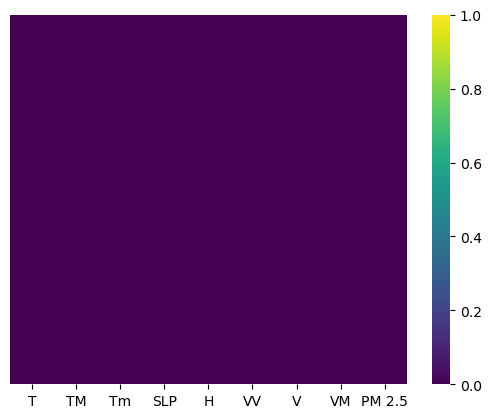

In [26]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=True,cmap='viridis')

In [27]:
df.describe()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,730.000000
mean,25.556908,32.231874,19.273598,1008.196854,64.134063,1.891929,6.630369,15.696580,107.929150
std,7.286760,6.852548,7.454202,7.564601,15.460460,0.686446,3.967064,7.654019,82.576607
min,6.700000,9.800000,0.000000,991.500000,20.000000,0.300000,0.400000,1.900000,0.000000
25%,18.850000,27.550000,12.000000,1001.300000,55.000000,1.400000,3.500000,11.100000,43.583333
50%,27.700000,34.100000,21.000000,1008.500000,66.000000,1.900000,6.300000,14.800000,81.729167
75%,31.200000,36.900000,25.900000,1015.000000,75.000000,2.400000,9.100000,18.300000,153.934375
max,38.500000,45.500000,32.700000,1023.200000,98.000000,5.800000,24.400000,57.600000,404.500000


In [5]:
df=df.dropna() #drop null values

Check for numerical and categorical features next, if there are any categorical feature convert them as value subsets 1, 2, 3 etc..

Here there are no categorical feature so we are not doing anything

### Split features

In [6]:
X=df.iloc[:,:-1] ## independent feature
y=df.iloc[:,-1] ## dependent feature

In [7]:
X.isnull()

,T,TM,Tm,SLP,H,VV,V,VM
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
726,False,False,False,False,False,False,False,False
727,False,False,False,False,False,False,False,False
728,False,False,False,False,False,False,False,False
729,False,False,False,False,False,False,False,False


If I have many feature and see how each feature behave and how much correlation it has with the other feature use pair plot

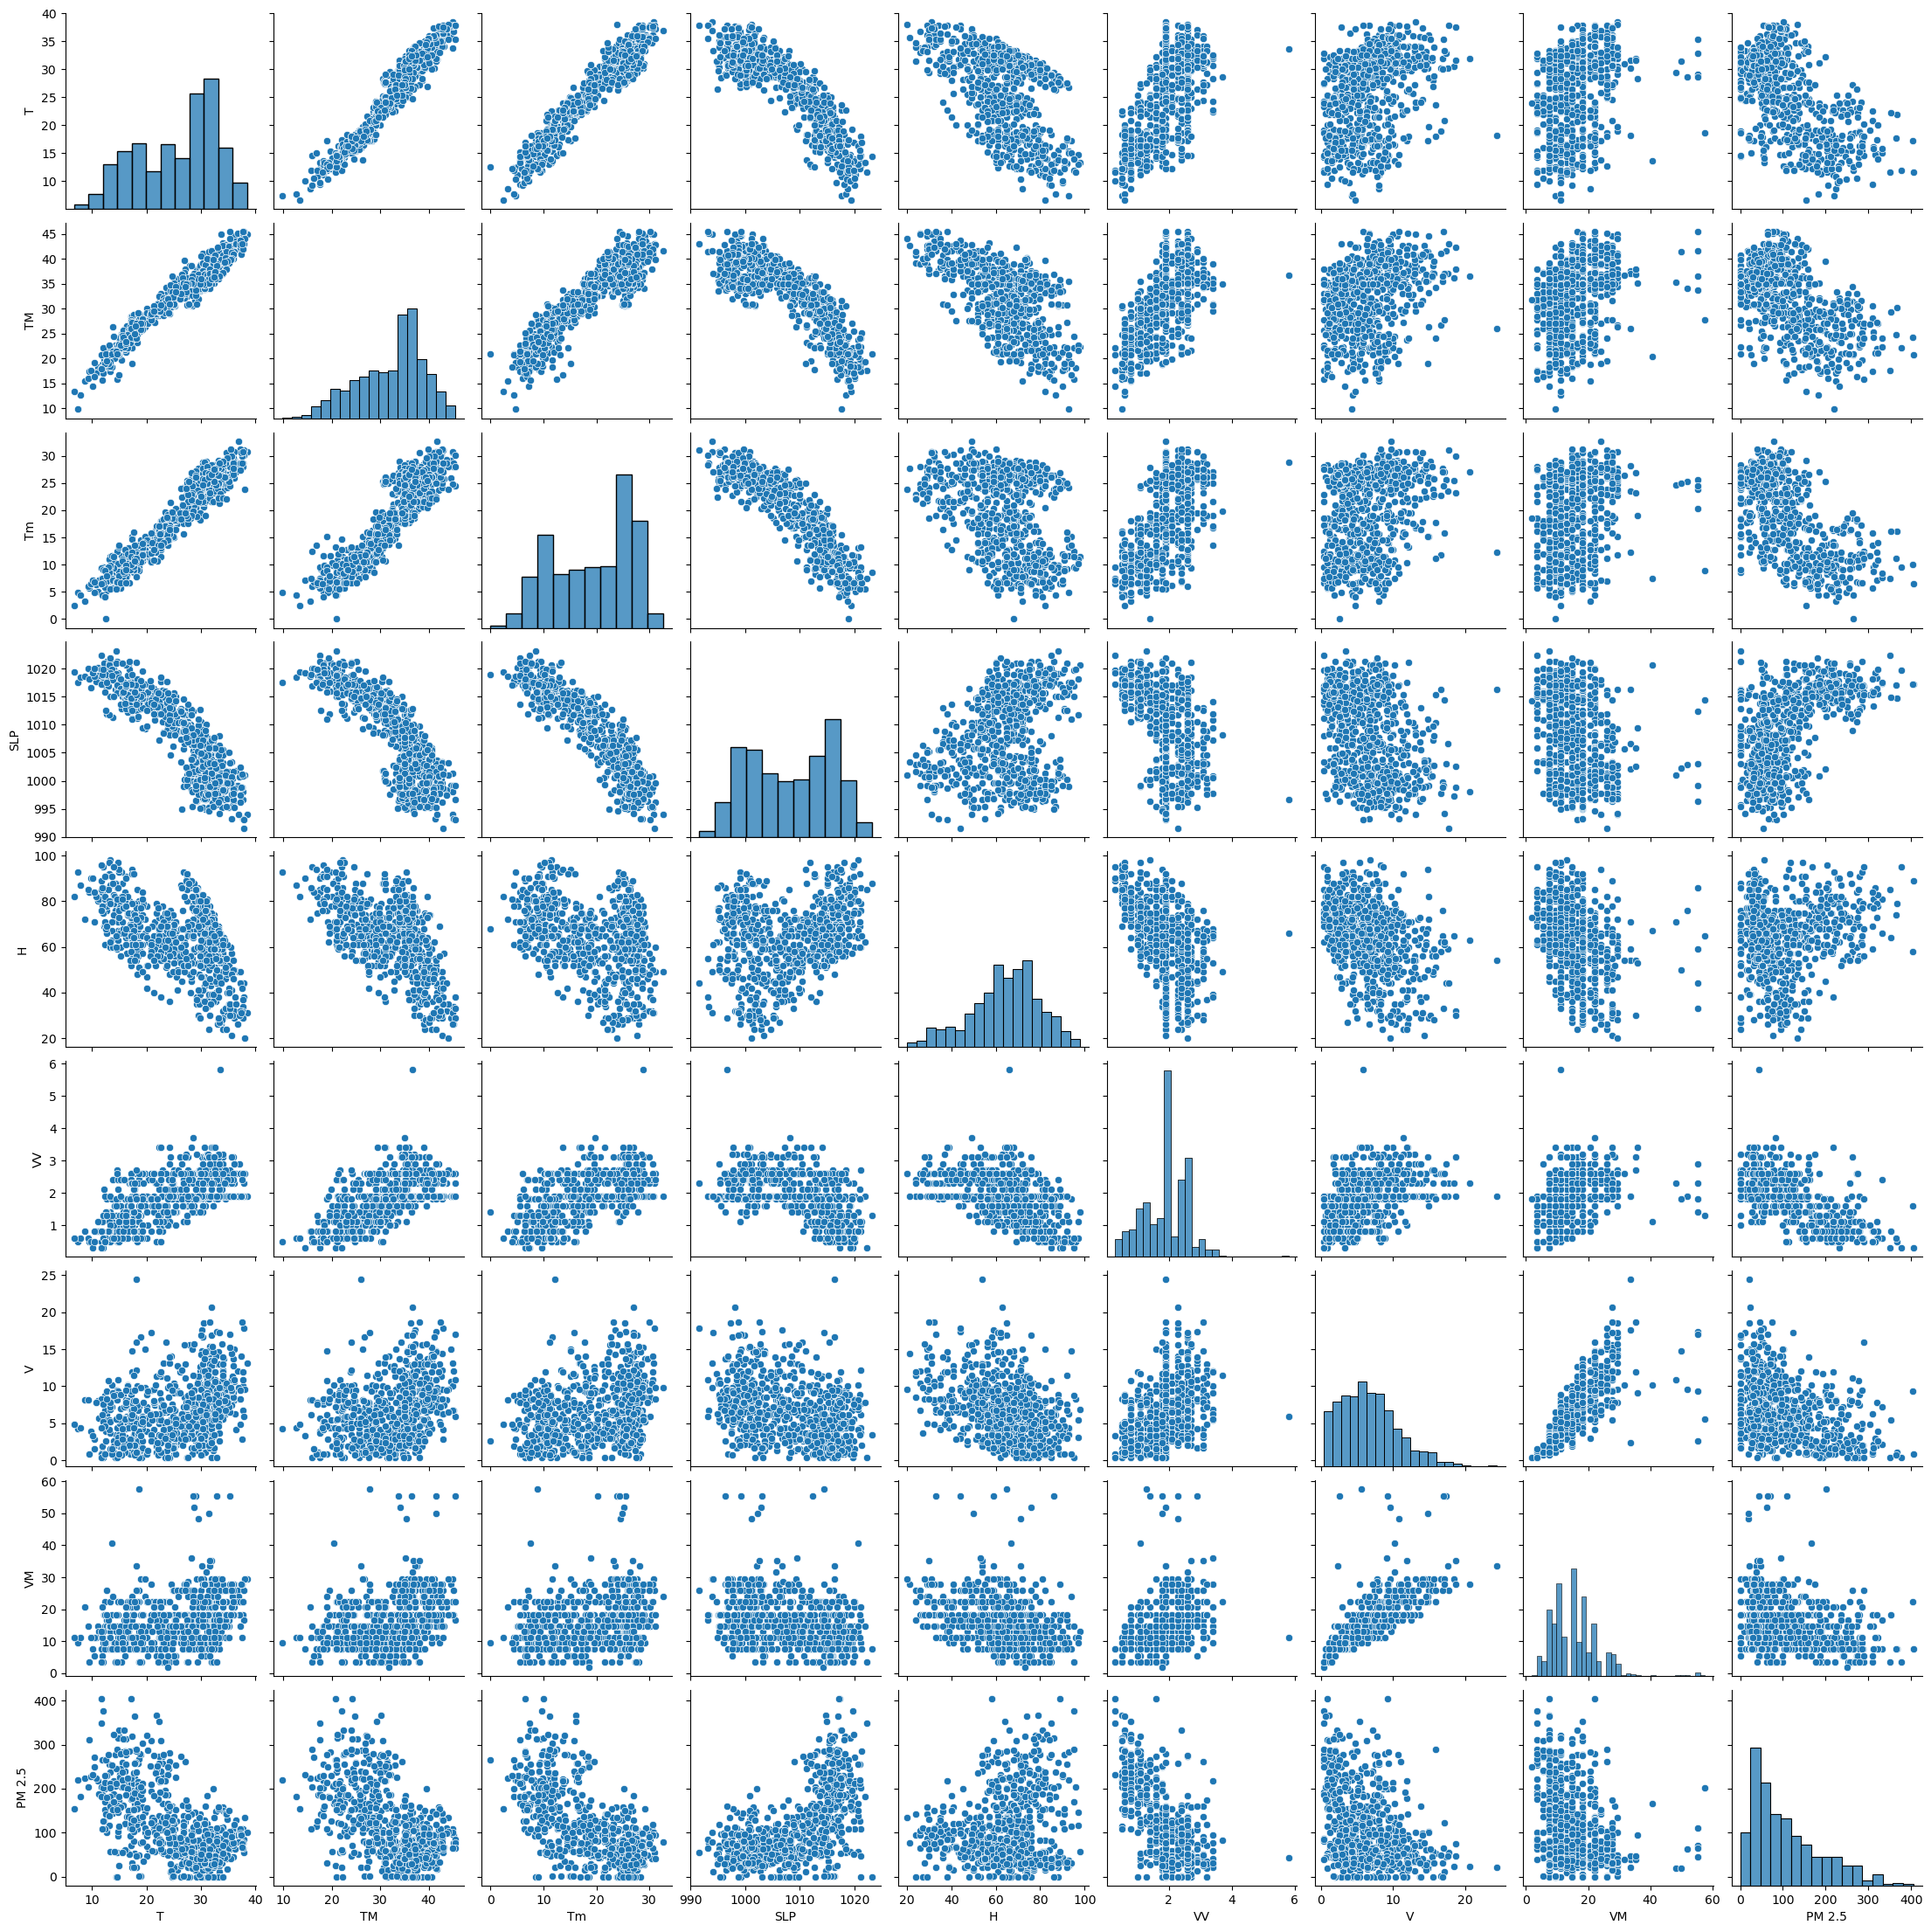

In [34]:
sns.pairplot(df)

To find the exact correlation between each feature we can use below command, if they correlate we can remove some feature as they are redundant

In [35]:
df.corr()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
T,1.000000,0.967276,0.958892,-0.884383,-0.518870,0.622637,0.326067,0.287138,-0.628336
TM,0.967276,1.000000,0.896699,-0.829254,-0.599629,0.598479,0.320116,0.299508,-0.569381
Tm,0.958892,0.896699,1.000000,-0.909514,-0.315305,0.560299,0.312904,0.259431,-0.669059
SLP,-0.884383,-0.829254,-0.909514,1.000000,0.274196,-0.491842,-0.346130,-0.299830,0.615615
H,-0.518870,-0.599629,-0.315305,0.274196,1.000000,-0.475279,-0.399079,-0.370981,0.174658
VV,0.622637,0.598479,0.560299,-0.491842,-0.475279,1.000000,0.402884,0.347493,-0.628621
V,0.326067,0.320116,0.312904,-0.346130,-0.399079,0.402884,1.000000,0.760777,-0.354799
VM,0.287138,0.299508,0.259431,-0.299830,-0.370981,0.347493,0.760777,1.000000,-0.283695
PM 2.5,-0.628336,-0.569381,-0.669059,0.615615,0.174658,-0.628621,-0.354799,-0.283695,1.000000


We can also use heatmap to understand the correlation better

<Axes: >

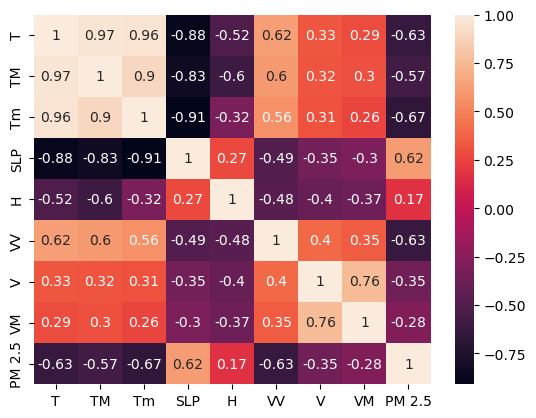

In [36]:
sns.heatmap(df[df.corr().index].corr(),annot=True)

If we see above plot, we need to compare the independent features with the dependent feature and see what has very less correlation. If it is highly correlated we can ignore them

### Feature Importance

In [10]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X,y)
print(df.columns)
print(model.feature_importances_)

Index(['T', 'TM', 'Tm', 'SLP', 'H', 'VV', 'V', 'VM', 'PM 2.5'], dtype='object')
[0.15062408 0.10009437 0.17509413 0.14227777 0.08167808 0.25736853
 0.052468   0.04039504]


<Axes: xlabel='PM 2.5', ylabel='Count'>

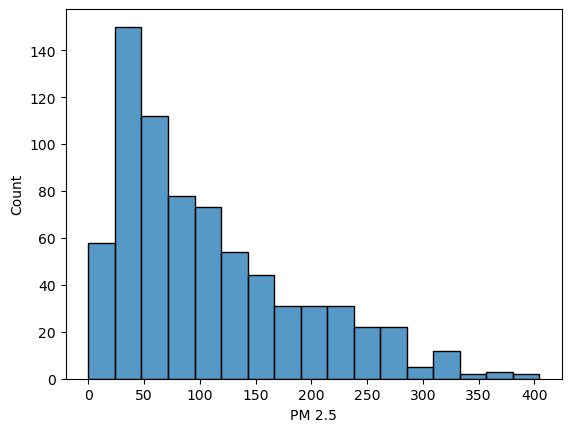

In [47]:
sns.histplot(y)

### Train test split

Train Test splot 70% 30%

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

### Model 

In [12]:
from sklearn.linear_model import LinearRegression

regressor=LinearRegression()
regressor.fit(X_train,y_train)

print( "R^2 on train set : {}".format(regressor.score(X_train,y_train))) 

R^2 on train set : 0.5997638989525959


With Linear regression it fits only 59.97%

In [13]:
print( "R^2 on train set : {}".format(regressor.score(X_test,y_test))) 

R^2 on train set : 0.508484631831946


Cross validation score helps us to run multiple iteration and give us the score

In [14]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=6)
score.mean()

0.4831045466268297

#### Intercept or slop -> intercept is what is y value if x is zero, coefficient gives the relation value with dependent feature

In [55]:
regressor.coef_

array([ 1.46741147e+00,  4.23350462e-01, -6.95118759e+00,  2.20375282e-01,
       -9.24397494e-01, -4.59934762e+01, -3.05239092e+00, -2.89304651e-02])

In [56]:
regressor.intercept_

137.90909220191185

In [15]:
pd.DataFrame(regressor.coef_,X.columns,columns=['Coeffient'])

,Coeffient
T,1.467411
TM,0.423350
Tm,-6.951188
SLP,0.220375
H,-0.924397
VV,-45.993476
V,-3.052391
VM,-0.028930


### Model Prediction

In [16]:
prediction=regressor.predict(X_test)

C:\Users\arsar\AppData\Local\Temp\ipykernel_16336\1520944062.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


<Axes: xlabel='PM 2.5', ylabel='Density'>

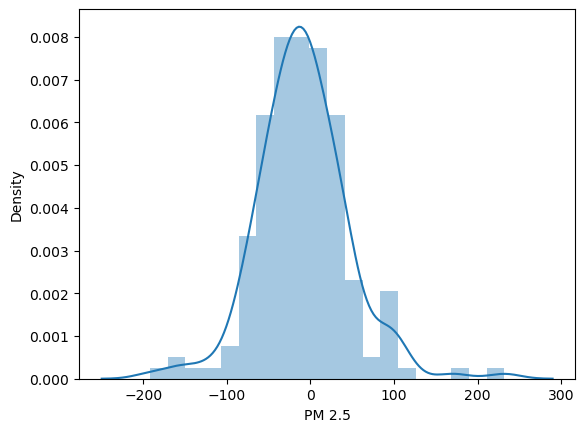

In [17]:
sns.distplot(y_test-prediction)

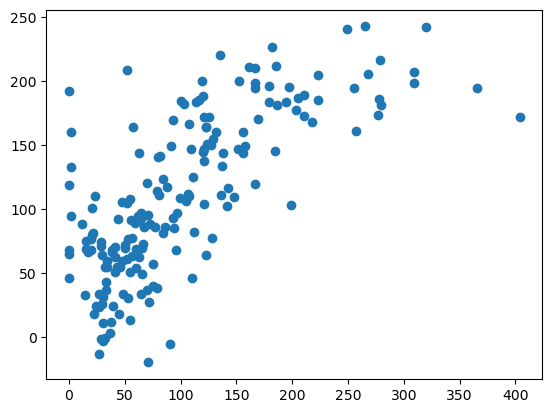

In [18]:
plt.scatter(y_test,prediction)

In [ ]:
### Model evaluation

In [19]:
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 40.754775414000264
MSE: 3036.513033034572
RMSE: 55.10456453901593


### Pickle file

In [64]:
import pickle 

# open a file, where you ant to store the data
file = open('regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(regressor, file)

## Comparison of models

### Linear Regression

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_reg=LinearRegression()
mse=cross_val_score(lin_reg,X,y,scoring='neg_mean_squared_error',cv=5)
print(np.mean(mse))

-3499.3561872902087


### Ridge Regression

In [22]:
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.linear_model import Ridge

ridge=Ridge()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)
ridge_regressor.fit(X,y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40]},
             scoring='neg_mean_squared_error')

In [23]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 40}
-3354.6171573071247


### Lasso Regression

In [24]:
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.linear_model import Lasso

las=Lasso()
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}
lasso_regressor=GridSearchCV(las,parameters,scoring='neg_mean_squared_error',cv=5)
lasso_regressor.fit(X,y)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.008e+05, tolerance: 4.247e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.110e+05, tolerance: 3.871e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.945e+05, toleranc

{'alpha': 5}
-3356.410256970684


### Evaluate best model

C:\Users\arsar\AppData\Local\Temp\ipykernel_16336\2668476692.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


<Axes: xlabel='PM 2.5', ylabel='Density'>

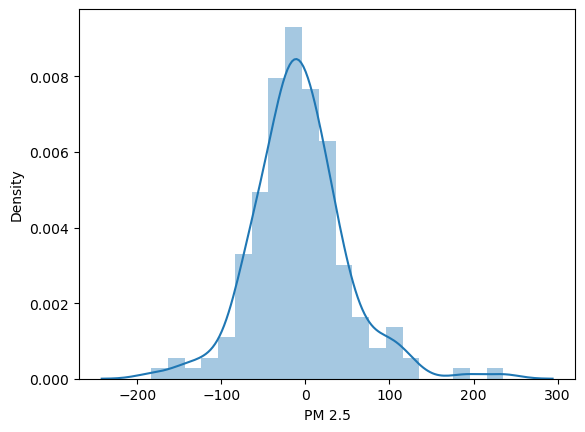

In [27]:
prediction=lasso_regressor.predict(X_test)

sns.distplot(y_test-prediction)


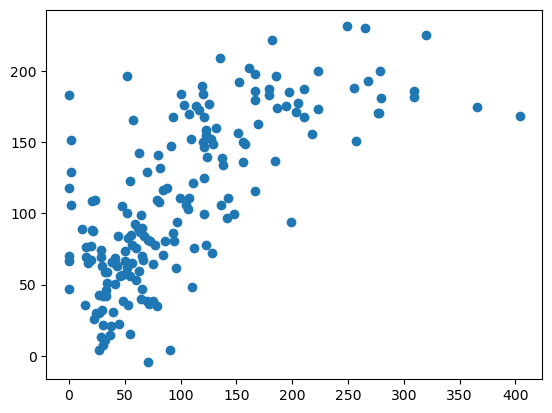

In [28]:
plt.scatter(y_test,prediction)

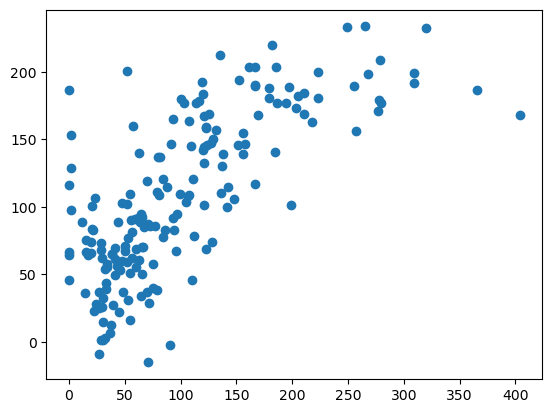

In [29]:
plt.scatter(y_test,ridge_regressor.predict(X_test))

In [30]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 40.82780189352587
MSE: 3105.7437517816325
RMSE: 55.72920017173791


In [31]:
import pickle 
# open a file, where you ant to store the data
file = open('lasso_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(lasso_regressor, file)

### Decision Tree Regressor

In [34]:
from sklearn.tree import DecisionTreeRegressor

dtree=DecisionTreeRegressor(criterion="squared_error")
dtree.fit(X_train,y_train)
print("Coefficient of determination R^2 <-- on train set: {}".format(dtree.score(X_train, y_train)))
print("Coefficient of determination R^2 <-- on test set: {}".format(dtree.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
score=cross_val_score(dtree,X,y,cv=5)
score.mean()

Coefficient of determination R^2 <-- on train set: 1.0
Coefficient of determination R^2 <-- on test set: 0.37273590315852145


0.08482412490731298

Above is a best example of overfitting as the coeff is less for test data

In [35]:
pred=dtree.predict(X_test)

C:\Users\arsar\AppData\Local\Temp\ipykernel_16336\731847810.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-pred)


<Axes: xlabel='PM 2.5', ylabel='Density'>

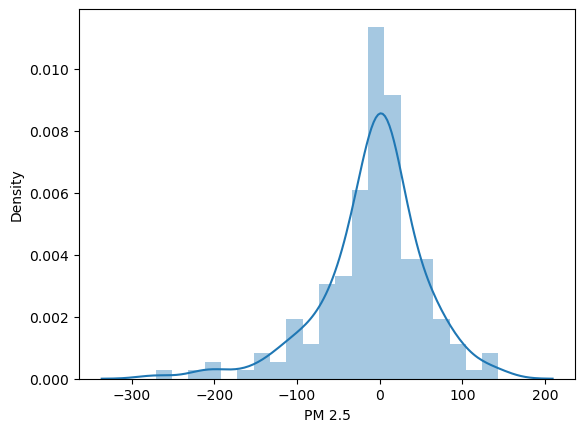

In [36]:
sns.distplot(y_test-pred)

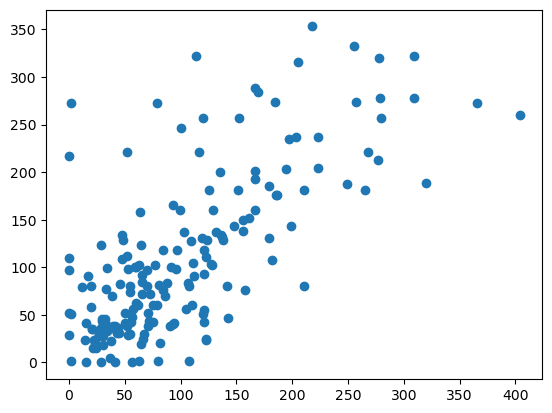

In [37]:
plt.scatter(y_test,pred)

### Hyper Parameter tuning

Fitting 10 folds for each of 10240 candidates, totalling 102400 fits


C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
25600 fits failed out of a total of 102400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
19222 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\arsar\anaconda3\Lib\site

MAE: 40.60905859054812
MSE: 3210.437088277588
RMSE: 56.660719094250716


C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [           nan            nan            nan ... -4668.52138573
 -4485.89917577 -5580.44201178]
  warnings.warn(
C:\Users\arsar\AppData\Local\Temp\ipykernel_16336\176796490.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-predictions)


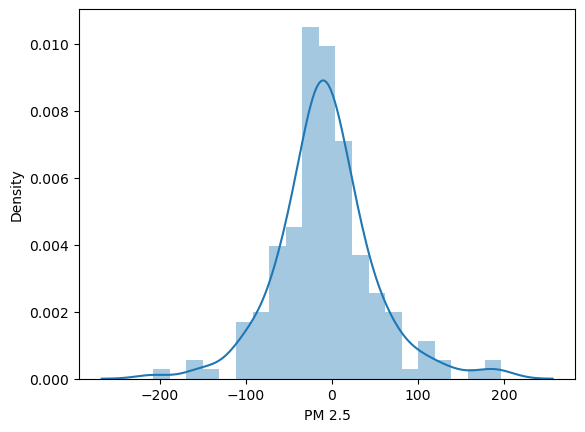

In [38]:
from sklearn.model_selection import GridSearchCV

## Hyper Parameter Optimization

params={
 "splitter"    : ["best","random"] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_samples_leaf" : [ 1,2,3,4,5 ],
"min_weight_fraction_leaf":[0.1,0.2,0.3,0.4],
 "max_features" : ["auto","log2","sqrt",None ],
    "max_leaf_nodes":[None,10,20,30,40,50,60,70]
    
}

random_search=GridSearchCV(dtree,param_grid=params,scoring='neg_mean_squared_error',n_jobs=-1,cv=10,verbose=3)

random_search.fit(X,y)

predictions=random_search.predict(X_test)

sns.distplot(y_test-predictions)

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

In [40]:
import pickle 

# open a file, where you ant to store the data
file = open('decision_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(random_search, file)

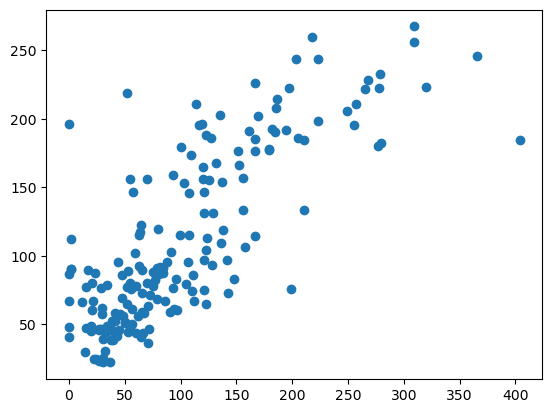

In [50]:
plt.scatter(y_test,prediction)

### Random Forest Regressor

Coefficient of determination R^2 <-- on train set: 0.9486870920731494
Coefficient of determination R^2 <-- on train set: 0.6124101290186145


C:\Users\arsar\AppData\Local\Temp\ipykernel_16336\326973234.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


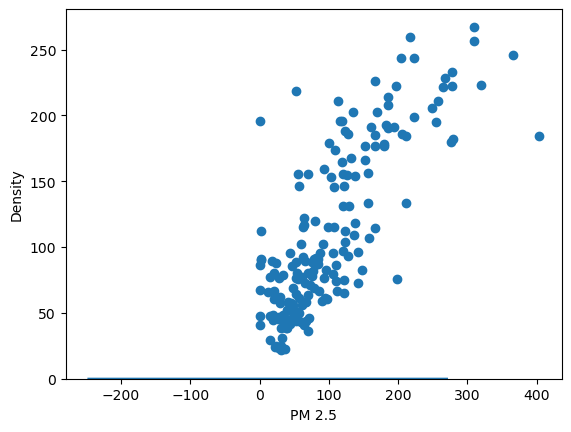

In [43]:
from sklearn.ensemble import RandomForestRegressor

regressor=RandomForestRegressor()
regressor.fit(X_train,y_train)

print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_train, y_train)))
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_test, y_test)))

from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=5)
score.mean()

prediction=regressor.predict(X_test)
sns.distplot(y_test-prediction)
plt.scatter(y_test,prediction)

### Hyper parameter tuning 

In [44]:
RandomForestRegressor()

from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = 1)

rf_random.fit(X_train,y_train)


[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=400; total time=   0.8s
[CV] END max_depth=20, max_featu

C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
160 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
160 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\arsar\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\arsar\anaconda3\Lib\site-packag

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [47]:
rf_random.best_score_

-2624.1993335207494

In [46]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20}

C:\Users\arsar\AppData\Local\Temp\ipykernel_16336\1349798091.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-predictions)


<Axes: xlabel='PM 2.5', ylabel='Density'>

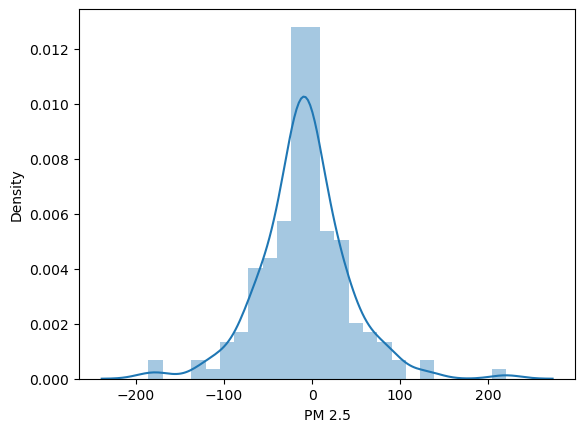

In [48]:
predictions=rf_random.predict(X_test)

sns.distplot(y_test-predictions)

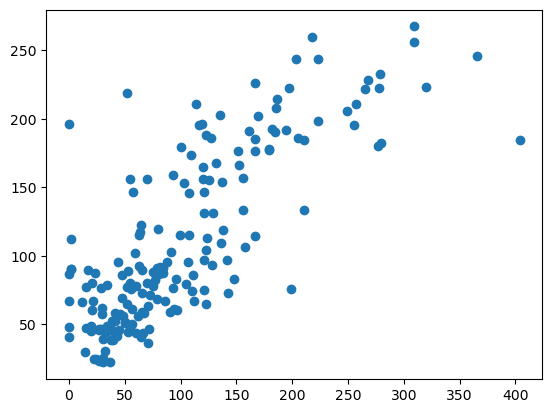

In [49]:
plt.scatter(y_test,prediction)

In [51]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))


MAE: 36.01514540724271
MSE: 2570.2108908591454
RMSE: 50.69724736964666


In [52]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 35.00322313296903
MSE: 2394.4758819926947
RMSE: 48.93338208209907


In [53]:
import pickle 
# open a file, where you ant to store the data
file = open('random_forest_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

### Xg Boost Regressor

Use this command to install XgBoost <i>conda install -c ananconda py-xgboost</i>

In [10]:
import xgboost as xgb
#conda install -c ananconda py-xgboost

regressor=xgb.XGBRegressor()
regressor.fit(X_train,y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_train, y_train)))

Coefficient of determination R^2 <-- on train set: 0.9997361098281123


In [12]:
print("Coefficient of determination R^2 <-- on train set: {}".format(regressor.score(X_test, y_test)))

Coefficient of determination R^2 <-- on train set: 0.633139083368649


In [13]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(regressor,X,y,cv=5)

score.mean()

0.4608540457492545

In [14]:
prediction=regressor.predict(X_test)

C:\Users\arsar\AppData\Local\Temp\ipykernel_14228\1520944062.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-prediction)


<Axes: xlabel='PM 2.5', ylabel='Density'>

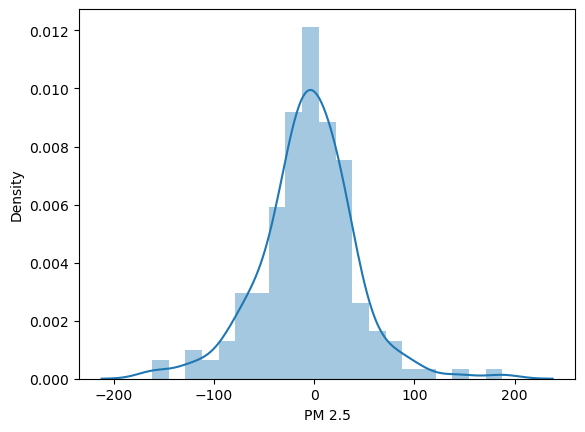

In [15]:
sns.distplot(y_test-prediction)

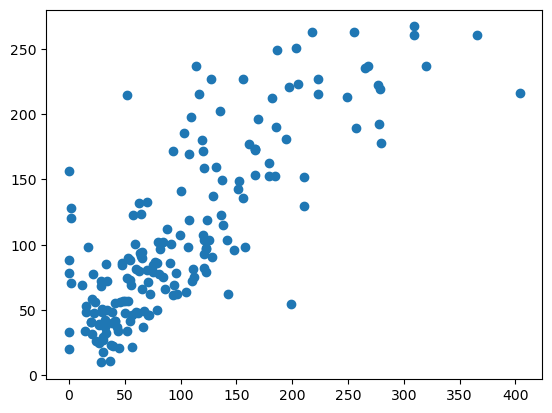

In [16]:
plt.scatter(y_test,prediction)

### Hyper Parameter tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV

xgb.XGBRegressor()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
print(n_estimators)

#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 12)]
# Various learning rate parameters
learning_rate = ['0.005','0.05','0.1', '0.2','0.3','0.5','0.6']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
#Subssample parameter values
subsample=[0.7,0.6,0.8]
# Minimum child weight parameters
min_child_weight=[3,4,5,6,7]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'min_child_weight': min_child_weight}

print(random_grid)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
{'n_estimators': [100, 227, 354, 481, 609, 736, 863, 990, 1118, 1245, 1372, 1500], 'learning_rate': ['0.005', '0.05', '0.1', '0.2', '0.3', '0.5', '0.6'], 'max_depth': [5, 10, 15, 20, 25, 30], 'subsample': [0.7, 0.6, 0.8], 'min_child_weight': [3, 4, 5, 6, 7]}


In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
regressor=xgb.XGBRegressor()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
xg_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 500, cv = 5, verbose=2, random_state=42, n_jobs = 1)

xg_random.fit(X_train,y_train)


Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END learning_rate=0.6, max_depth=15, min_child_weight=4, n_estimators=354, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.6, max_depth=15, min_child_weight=4, n_estimators=354, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.6, max_depth=15, min_child_weight=4, n_estimators=354, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.6, max_depth=15, min_child_weight=4, n_estimators=354, subsample=0.7; total time=   0.1s
[CV] END learning_rate=0.6, max_depth=15, min_child_weight=4, n_estimators=354, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=6, n_estimators=481, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=6, n_estimators=481, subsample=0.7; total time=   0.2s
[CV] END learning_rate=0.5, max_depth=25, min_child_weight=6, n_estimators=481, subsample=0.7; total time=   0.3s
[CV] END learning_rate=0

C:\Users\arsar\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=500, n_jobs=1,
                   param_distributions={'learning_rate': ['0.005', '0.05',
                                                          '0.1', '0.2', '0.3',
                                                          '0.5', '0.6'],
                                        'max_depth': [5, 10, 15, 20, 25, 30],
                                        'min_child_weight': [3, 4, 5, 6, 7],
                                        'n_estimators': [100, 227, 354, 481,
                                                         609, 736, 863, 990,
                                                         1118, 1245, 1372,
                                                         1500],
                                        'subsample': [0.7, 0.6, 0.8]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [19]:
xg_random.best_params_

{'subsample': 0.6,
 'n_estimators': 863,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': '0.005'}

In [20]:
xg_random.best_score_

-2639.046584830021

In [21]:
predictions=xg_random.predict(X_test)

C:\Users\arsar\AppData\Local\Temp\ipykernel_14228\2131792714.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test-predictions)


<Axes: xlabel='PM 2.5', ylabel='Density'>

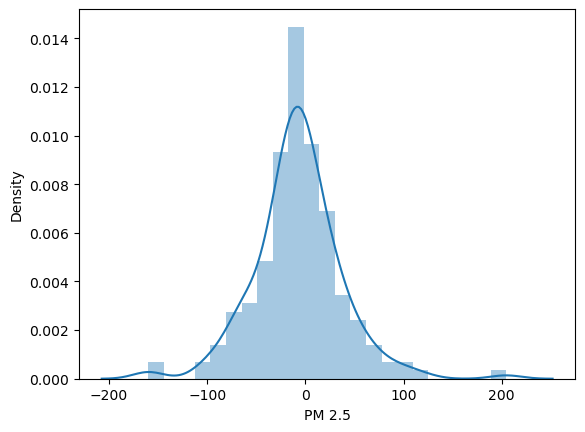

In [22]:
sns.distplot(y_test-predictions)

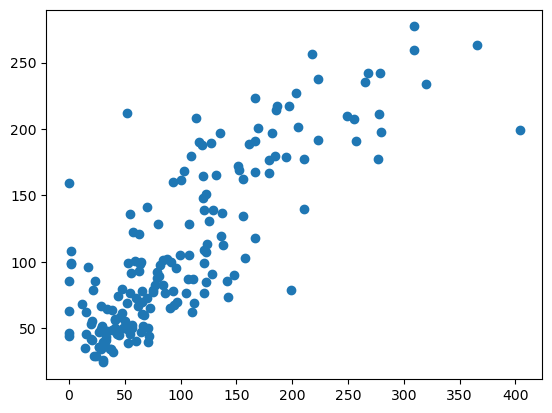

In [23]:
plt.scatter(y_test,predictions)

In [24]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 32.270375154839186
MSE: 2047.2834377983825
RMSE: 45.2469163346894


In [25]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 32.270375154839186
MSE: 2047.2834377983825
RMSE: 45.2469163346894


In [26]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 34.34671939578864
MSE: 2266.4153082619923
RMSE: 47.60688299250427


In [28]:
import pickle 

# open a file, where you ant to store the data
file = open('random_forest_regression_model.pkl', 'wb')

# dump information to that file
pickle.dump(xg_random, file)